In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Cargar datos
df = pd.read_csv('Mall_Customers.csv')

# Limpiar y convertir 'Genre' a numérico
df['Gender'] = df['Gender'].str.strip()  # Eliminar espacios en blanco al principio y al final
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB
None
       CustomerID      Gender         Age  Annual Income (k$)  \
count  200.000000  200.000000  200.000000          200.000000   
mean   100.500000    0.560000   38.850000           60.560000   
std     57.879185    0.497633   13.969007           26.264721   
min      1.000000    0.000000   18.000000           15.000000   
25%     50.750000    0.000000   28.750000           41.500000   
50%    100.500000    1.000000   36.000000           61.500000   
75%    150.250000    1.000000   49.000000

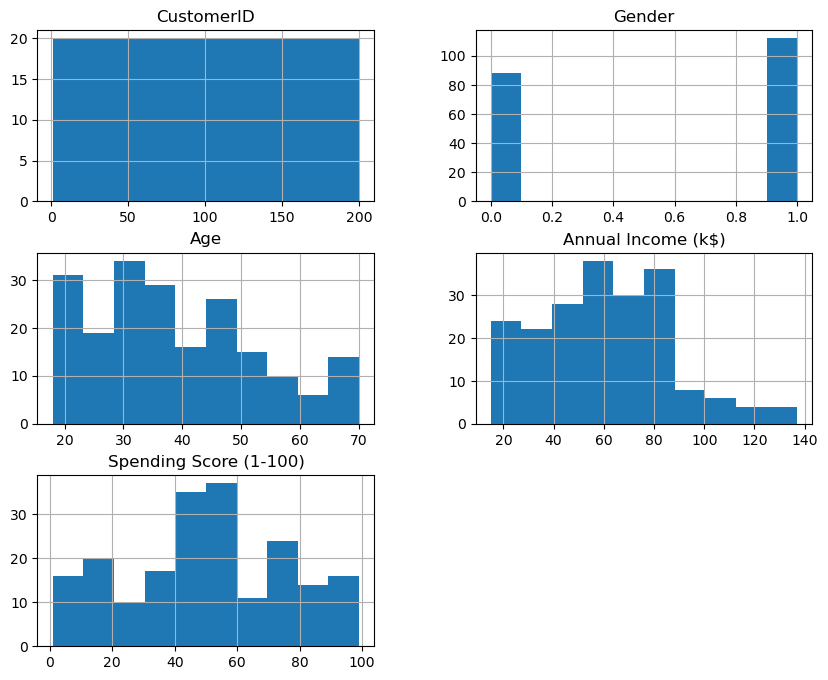

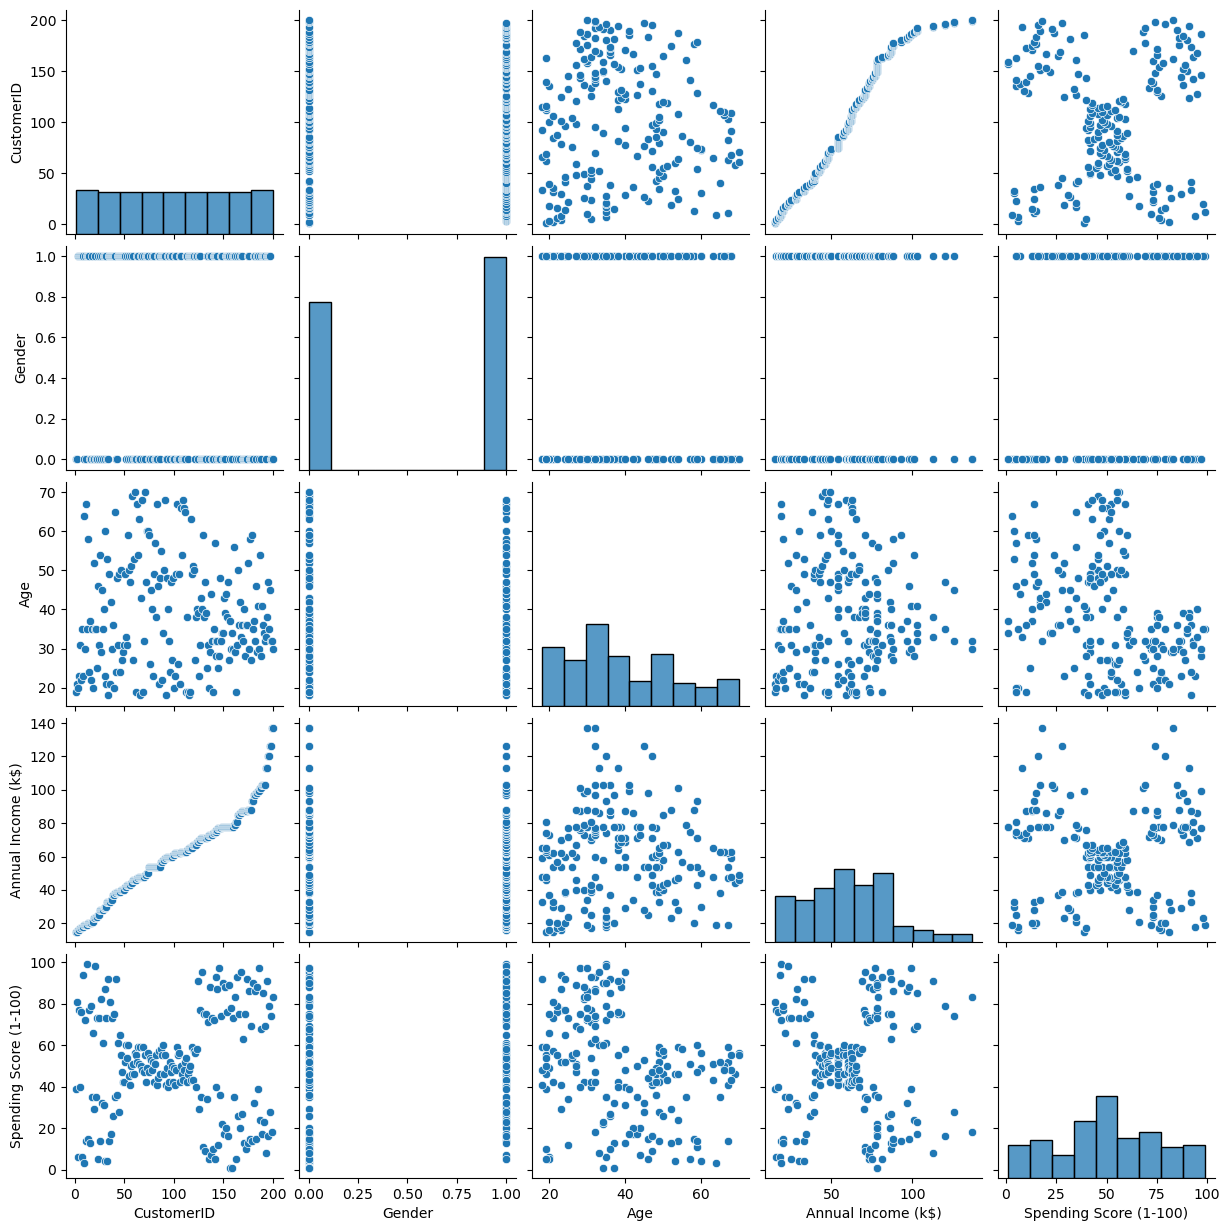

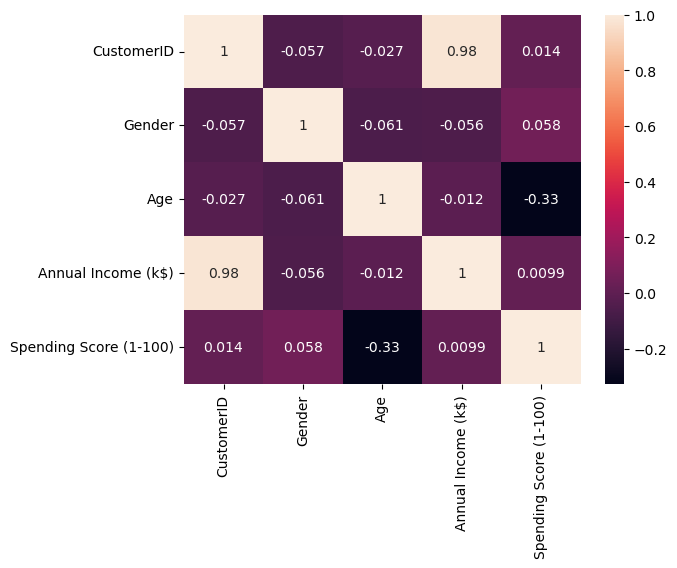

In [2]:
# Información general del dataset
print(df.info())

# Estadísticas descriptivas
print(df.describe())

# Visualización de la distribución de variables numéricas
df.hist(figsize=(10, 8))
plt.show()

# Visualización de la relación entre variables
sns.pairplot(df)
plt.show()

# Análisis de correlación
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [4]:
# Preprocesamiento (el resto del preprocesamiento)
df = df.drop('CustomerID', axis=1)  # Eliminar 'CustomerID' DESPUÉS de la correlación si no se quiere incluir

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)

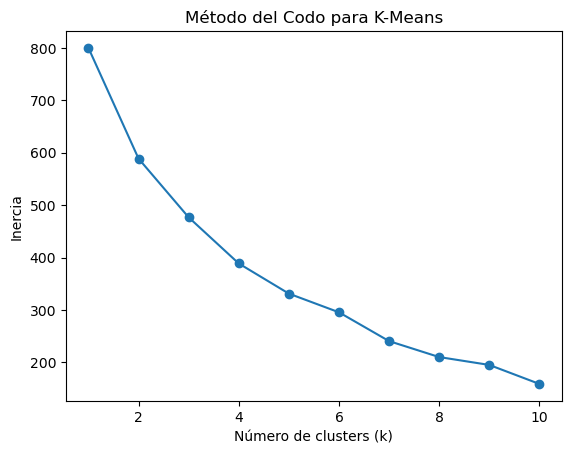

Silhouette Score (K-Means): 0.2989559018050562
Calinski-Harabasz Index (K-Means): 69.10934612686053
Davies-Bouldin Index (K-Means): 1.282142247400729


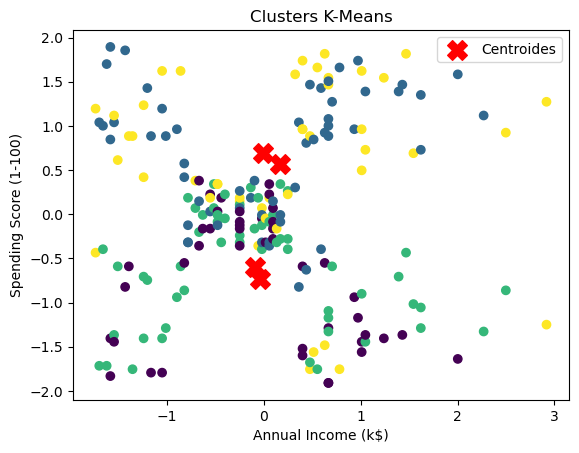

                Gender        Age  Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                                               
0                  0.0  52.511628           59.395349               31.441860
1                  1.0  28.392857           60.428571               68.178571
2                  1.0  47.803571           58.071429               34.875000
3                  0.0  27.666667           64.933333               64.822222


In [5]:
# K-Means: Determinar el número óptimo de clusters (método del codo)
inertia = []
for k in range(1, 11):  # Prueba con diferentes valores de k
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.show()

# K-Means: Ajustar el modelo con el k óptimo (ej. k=4, o el valor que el método del codo sugiera)
k_optimo = 4  # Reemplaza con el valor óptimo encontrado
kmeans = KMeans(n_clusters=k_optimo, random_state=0)
kmeans.fit(df_scaled)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Evaluación de K-Means
silhouette_kmeans = silhouette_score(df_scaled, labels)
calinski_kmeans = calinski_harabasz_score(df_scaled, labels)
davies_kmeans = davies_bouldin_score(df_scaled, labels)

print(f'Silhouette Score (K-Means): {silhouette_kmeans}')
print(f'Calinski-Harabasz Index (K-Means): {calinski_kmeans}')
print(f'Davies-Bouldin Index (K-Means): {davies_kmeans}')


# Visualización de K-Means (ejemplo con dos variables)
plt.scatter(df_scaled['Annual Income (k$)'], df_scaled['Spending Score (1-100)'], c=labels)
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], s=200, c='red', marker='X', label='Centroides') #Visualizar centroides
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Clusters K-Means')
plt.legend()
plt.show()


# Añadir las etiquetas de los clusters al DataFrame original para su análisis
df['KMeans_Cluster'] = labels

# Analizar las características de cada cluster (ej. media de cada variable por cluster)
print(df.groupby('KMeans_Cluster').mean())